In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import src

%matplotlib inline

In [2]:
df_tmdb = pd.read_csv('../zippedData/tmdb.movies.csv.gz', index_col=0)
df_tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [3]:
df_budgets = pd.read_csv('tn.movie_budgets.csv')


In [4]:
df_rotten = pd.read_csv('rotten-sentiments.csv')
df_rotten.head()

,review,rating_x,fresh,critic,top_critic,publisher,date,synopsis,rating_y,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,genre_list,sentiment
0,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One,"['Drama', 'Science Fiction ', ' Fantasy']","{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compou..."
1,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One,"['Drama', 'Science Fiction ', ' Fantasy']","{'neg': 0.2, 'neu': 0.8, 'pos': 0.0, 'compound..."
2,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One,"['Drama', 'Science Fiction ', ' Fantasy']","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One,"['Drama', 'Science Fiction ', ' Fantasy']","{'neg': 0.228, 'neu': 0.702, 'pos': 0.07, 'com..."
4,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017","New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One,"['Drama', 'Science Fiction ', ' Fantasy']","{'neg': 0.359, 'neu': 0.641, 'pos': 0.0, 'comp..."


In [10]:
df_rotten.head(1)

,Unnamed: 0,id,review,rating_x,fresh,critic,top_critic,publisher,date,synopsis,...,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,genre_list,sentiment
0,0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018","New York City, not-too-distant-future: Eric Pa...",...,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One,"['Drama', 'Science Fiction ', ' Fantasy']","{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compou..."


In [35]:
df_rotten.date = pd.to_datetime(df_rotten.date)

In [65]:
df_rotten['month'] = df_rotten['date'].dt.strftime("%m") 
df_rotten['day'] = df_rotten['date'].dt.strftime('%d')

In [56]:
date_release_data = df_rotten.groupby(['month_day']).date.count()

In [58]:
date_release_data

month_day
01    7090
02    3960
03    3380
04    2992
05    2875
06    3125
07    3826
08    4305
09    3693
10    4422
11    4338
12    4783
Name: date, dtype: int64

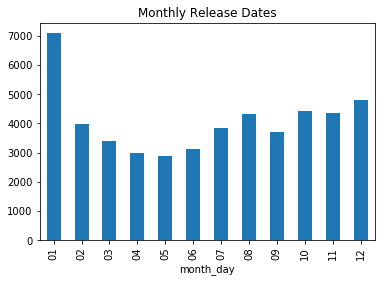

In [75]:
date_release_data.plot(kind='bar', title='Monthly Release Dates');

Let's specifically look into the month of january. See if there is any macro trends


In [69]:
january_release_date = df_rotten[df_rotten.month == '01'].groupby(['day']).date.count()

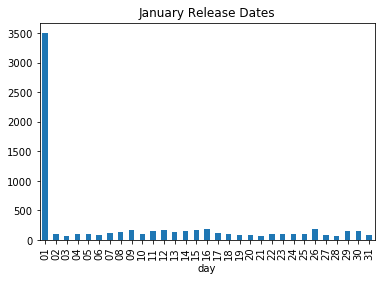

In [73]:
january_release_date.plot(kind='bar', title='January Release Dates');

In [ ]:
sentiment_date_data= df_rotten.groupby(['date']).date.count()